In [16]:
import os, sys
import numpy as np
import imageio
import json
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

from run_nerf_helpers import *

from load_blender import load_blender_data
from run_simple_nerf_student import render_rays_discrete, create_pointcloud

'''
load all neccesary functions!
'''

'\nload all neccesary functions!\n'

In [9]:
K = None
device = 'cpu'

# 
N_samples = 200
pts_res = 200
pts_max = 3.725

path_dataset =  'data/nerf_synthetic/lego'

images, poses, render_poses, hwf, i_split = load_blender_data(path_dataset, True, 8)
print('Loaded blender', images.shape, render_poses.shape, hwf)

i_train, _, _ = i_split

near = 2.
far = 6.
# obtain images with white background
images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])


# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

if K is None:
    K = np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

    
'''

You should load your rgb, sigma
'''



main_folder_name = 'resources'
path_pt_cloud = 'logs/Train_lego/'

# create point cloud
pt_cloud = torch.load(path_pt_cloud+'/pts_clous.tns').cpu()

sigma_val = torch.load(path_pt_cloud+'/01000/sigma_1000.tns').cpu()
rgb_val =  torch.load(path_pt_cloud+'/01000/rgb_1000.tns').cpu()

# transerer everything on device
sigma_val = sigma_val.to(device)
rgb_val = rgb_val.to(device)
pt_cloud = pt_cloud.to(device)


# change the path where you want to save!!!!
save_folder_test_img = os.path.join('logs', main_folder_name, 'novel_views')
save_folder_train_img = os.path.join('logs', main_folder_name, 'gt_views')
os.makedirs(save_folder_test_img , exist_ok=True)
os.makedirs(save_folder_train_img , exist_ok=True)

Loaded blender (138, 40, 40, 4) torch.Size([40, 4, 4]) [40, 40, 55.55555155968841]


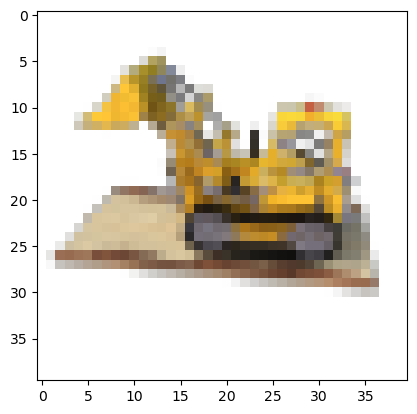

In [10]:
plt.imshow(images[25])
plt.show()

In [11]:
novel_imgs_display = []
for j in trange(100,poses.shape[0], 1):

    pose = poses[j, :3,:4]
    rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)

    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)

    coords = torch.reshape(coords, [-1,2])  # (H * W, 2)

    chunk = 200
    # N_rand = chunk
    rgb_image = []
    for k in range(int(coords.size(0)/chunk)):
        select_coords = coords[k*chunk: (k+1)*chunk].long()  # (N_rand, 2)
        rays_o_batch = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        rays_d_batch = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)


        t_vals = torch.linspace(0., 1., steps=N_samples)
        z_vals = near * (1.-t_vals) + far * (t_vals)


        with torch.no_grad():
            # apply the same changes as above!!!
            ret = render_rays_discrete(ray_steps= z_vals,
                                       rays_o = rays_o_batch,
                                       rays_d = rays_d_batch,
                                       N_samples = N_samples,
                                       pt_cloud = pt_cloud, 
                                       rgb_val =rgb_val, 
                                       sigma_val = sigma_val,) 

        rgb_map = ret
        rgb_image.append(rgb_map)


        
    rgb_image = torch.cat(rgb_image)
    

    rgb_image = rearrange(rgb_image, '(w h) d -> w h d', w = W)


    rgbimage8 = to8b(rgb_image.cpu().numpy())
    filename = os.path.join(save_folder_test_img, '{:03d}.png'.format(j))
    imageio.imwrite(filename, rgbimage8)

100%|██████████| 38/38 [00:01<00:00, 19.76it/s]


In [13]:
for j in trange(0,100, 1):

    pose = poses[j, :3,:4]
    rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)

    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)

    coords = torch.reshape(coords, [-1,2])  # (H * W, 2)

    chunk = 200
    # N_rand = chunk
    rgb_image = []
    for k in range(int(coords.size(0)/chunk)):
        select_coords = coords[k*chunk: (k+1)*chunk].long()  # (N_rand, 2)
        rays_o_batch = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
        rays_d_batch = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)


        t_vals = torch.linspace(0., 1., steps=N_samples)
        z_vals = near * (1.-t_vals) + far * (t_vals)
        
        with torch.no_grad():
            # apply the same changes as above!!!
            ret = render_rays_discrete(ray_steps = z_vals,
                                       rays_o = rays_o_batch,
                                       rays_d = rays_d_batch,
                                       N_samples = N_samples,
                                       pt_cloud = pt_cloud, 
                                       rgb_val =rgb_val, 
                                       sigma_val = sigma_val) 

        rgb_map = ret
        rgb_image.append(rgb_map)

    rgb_image = torch.cat(rgb_image)

    rgb_image = rearrange(rgb_image, '(w h) d -> w h d', w = W)



    rgbimage8 = to8b(rgb_image.cpu().numpy())
    filename = os.path.join(save_folder_train_img, '{:03d}.png'.format(j))
    imageio.imwrite(filename, rgbimage8)

100%|██████████| 100/100 [00:04<00:00, 21.02it/s]


# Extract 3D Mesh

In [14]:
import mcubes 
import trimesh 

sigma_reshape = sigma_val.reshape(pts_res,pts_res,pts_res).cpu().numpy()
print(sigma_reshape.shape)
threshold = 10. # choose a reasonable threshold - 
print('fraction occupied', np.mean(sigma_reshape > threshold))
vertices, triangles = mcubes.marching_cubes(sigma_reshape, threshold)
print('done', vertices.shape, triangles.shape)
print((vertices / pts_res - .5))
mesh = trimesh.Trimesh(vertices / pts_res - .5, triangles)

# specify path
_ = mesh.export(os.path.join(save_folder_train_img, 'mesh.obj'.format(j)))

(200, 200, 200)
fraction occupied 0.0
done (0, 3) (0, 3)
[]
